# Linear Elasticity Deterministic Inverse Problem

This notebook uses `hippylib` to solve a deterministic inverse problem for an uncertain elastic modulus in a linear elasticity problem


## Linear elasticity

We can derive linear elasticity as the minimization of strain energy

$$
\min_u \int_\Omega \psi(\varepsilon(u)) dx - \int_\Omega f\cdot u dx - \int_{\Gamma_N} t \cdot n ds(x)
$$
where $\varepsilon(u) = \frac{1}{2}(\nabla u + \nabla u^T)$
where $u$ is restricted to an appropriate space to satisfy given Dirichlet boundary conditions, $f$ is a body load, and $t$ is a prescribed traction condition. Additionally:

$$
\psi(\boldsymbol{\varepsilon}) = \frac{\lambda}{2} \bigl(\mathrm{tr}(\boldsymbol{\varepsilon})\bigr)^2 + \mu \,\mathrm{tr}(\boldsymbol{\varepsilon}^2)
$$

The minimizer gives us the following system

$$ -\nabla \cdot \sigma(u) = f$$
$$ u = u_D \text{ on } \Gamma_D$$
$$ \sigma \cdot n = t \text{ on } \Gamma_N$$

$$ \sigma(u) = \lambda (\nabla \cdot u) I + 2\mu \varepsilon(u)$$


In our case we parametrize our model by the elastic modulus:

$$ E = \frac{\mu(3\lambda + 2\mu)}{\lambda + \mu} $$

and we assume the Poisson's ration $\nu = \frac{\lambda}{2(\lambda + \mu)} = 0.4$ to be fixed.

We generate training data samples of $E$ using Gaussian random fields $m$. We assume $E = 1 + \exp(m)$, in order to maintain the coercivity (well-posedness) of the PDE.

## Inverse Problem

We have pointwise observations of the displacements $u \in \mathcal{U}$. The observation operator is $B:\mathcal{U} \rightarrow \mathbb{R}^{d}$. The observational data $\mathbf{d}$ are assumed to agree with the true observations up to some irreducible observational noise $\xi \sim \mathcal{N}(0,\Gamma)$. That is $\mathbf{d} = Bu(m_\text{true}) + \xi$

The minimization problem is 

$$ \min_m \frac{1}{2}\|Bu(m) - \mathbf{d}\|^2_{\Gamma^{-1}} + \frac{1}{2}\|m - m_0\|^2_{\mathcal{C}^{-1}}$$

where $\mathcal{C}^{-1}$ is a weighting for a Tikhonov regularization, and in the Bayesian context we identify it with the covariance of a Gaussian prior, e.g., $\mu_\text{prior} = \mathcal{N}(m_0,\mathcal{C})$.

In [1]:
# MIT License
# Copyright (c) 2025
#
# This is part of the dino_tutorial package
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND.
# For additional questions contact Thomas O'Leary-Roseberry

import dolfin as dl
import ufl
import math
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import time
sys.path.append( os.environ.get('HIPPYLIB_PATH', "../") )
import hippylib as hp

from linear_elasticity_model import *

# sys.path.append( os.environ.get('HIPPYFLOW_PATH'))
# import hippyflow as hf

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

np.random.seed(seed=42)


Number of dofs: STATE=3322, PARAMETER=1661, ADJOINT=3322
Number of observation points: 50


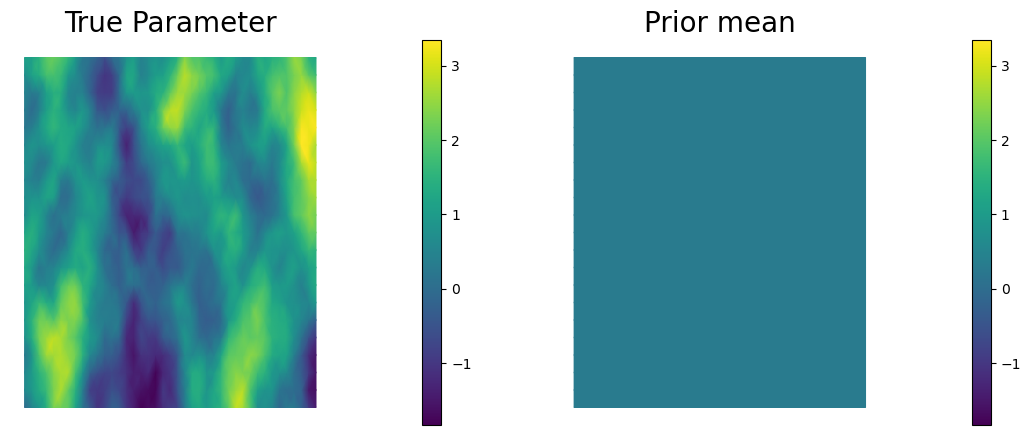

In [2]:
# Define some basic settings for 
settings = linear_elasticity_settings()
# Define model
model = linear_elasticity_model(settings)

Vh = model.problem.Vh

# Generate data:
############
noise = dl.Vector()
model.prior.init_vector(noise,"noise")
hp.parRandom.normal(1., noise)
mtrue = dl.Vector()
model.prior.init_vector(mtrue, 0)
model.prior.sample(noise, mtrue)

# mtrue = true_parameter(model.prior)
# plot mtrue, mean 
objs = [dl.Function(model.problem.Vh[hp.PARAMETER],mtrue), 
        dl.Function(model.problem.Vh[hp.PARAMETER],model.prior.mean)]
mytitles = ["True Parameter", "Prior mean"]
hp.utils.nb.multi1_plot(objs, mytitles)
plt.show()

utrue = model.problem.generate_state()
x = [utrue, mtrue, None]

model.problem.solveFwd(x[hp.STATE], x)
data = model.misfit.B*x[hp.STATE]
# MAX = data.norm("linf")
# noise_std_dev = rel_noise * MAX
hp.parRandom.normal_perturb(settings['noise_variance']**0.5, data)
model.misfit.d = data


In [3]:
q = dl.Vector()
model.misfit.B.init_vector(q,0)
print(q.get_local().shape)

(100,)


<Figure size 1500x1100 with 0 Axes>

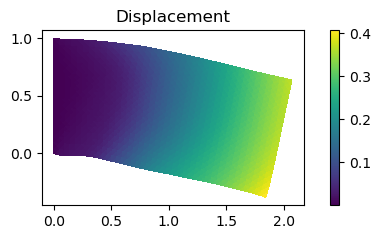

In [4]:

plt.figure(figsize=(15,11))
u_norm = get_unorm(model, utrue)

u_plot = dl.Function(Vh[hp.STATE])
u_plot.vector().zero()
u_plot.vector().axpy(1.,utrue)

vmax = u_norm.vector().max()
vmin = u_norm.vector().min()

# Project onto a scalar function space. Often, u0.function_space() is a scalar subspace.


plt.figure(figsize=(15,5))
plt.subplot(221)
cbar = dl.plot(u_plot, mode="displacement", title="Displacement")
_ = plt.colorbar(cbar)


# hp.utils.nb.plot(u_norm, mytitle="Absolute Value (u)", subplot_loc=221, vmin=vmin, vmax=vmax)
# norm = np.linalg.norm(model.misfit.d.get_local().reshape((-1, 2)), axis=1)
# tmp = dl.Vector(dl.MPI.comm_world, len(norm))
# tmp.set_local(norm)
# hp.utils.nb.plot_pts(model.targets, tmp, mytitle="Observations (u)", subplot_loc=222, vmin=vmin, vmax=vmax)


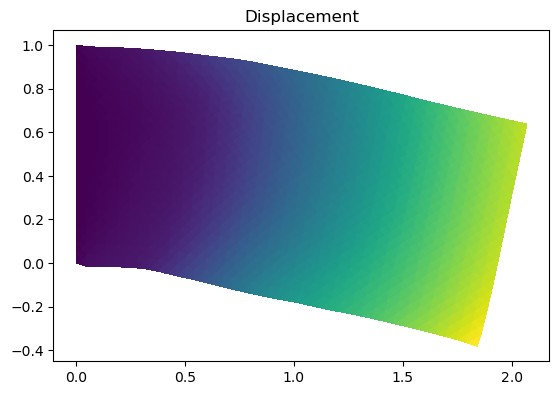

In [5]:
dl.plot(u_plot, mode="displacement", title="Displacement")

In [6]:
import hippylib.utils.nb as nb
# Compute MAP point
m = model.prior.mean.copy()
solver = hp.ReducedSpaceNewtonCG(model)
solver.parameters["rel_tolerance"] = 1e-6
solver.parameters["abs_tolerance"] = 1e-12
solver.parameters["max_iter"]      = 100
solver.parameters["GN_iter"] = 20
solver.parameters["globalization"] = "LS"
solver.parameters["LS"]["c_armijo"] = 1e-4

    
x = solver.solve([None, m, None])
    
if solver.converged:
    print( "\nConverged in ", solver.it, " iterations.")
else:
    print( "\nNot Converged")

print( "Termination reason: ", solver.termination_reasons[solver.reason] )
print( "Final gradient norm: ", solver.final_grad_norm )
print( "Final cost: ", solver.final_cost )


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    5.403117e+01    5.381416e+01    2.170189e-01   -1.223073e+02   4.336777e+02   1.000000e+00   5.000000e-01
  2   2    5.223946e+01    5.153215e+01    7.073132e-01   -3.763392e+00   2.174166e+01   1.000000e+00   2.239045e-01
  3   2    5.192724e+01    5.116650e+01    7.607405e-01   -6.265021e-01   1.311902e+01   1.000000e+00   1.739271e-01
  4   4    5.176752e+01    5.056542e+01    1.202103e+00   -3.395439e-01   4.074960e+00   1.000000e+00   9.693444e-02
  5   4    5.176593e+01    5.060438e+01    1.161545e+00   -3.788053e-03   7.365921e-01   1.000000e+00   4.121260e-02
  6   5    5.176587e+01    5.059672e+01    1.169145e+00   -1.584845e-04   6.444386e-02   1.000000e+00   1.219010e-02
  7   5    5.176586e+01    5.059814e+01    1.167723e+00   -8.591440e-06   1.488712e-02   1.000000e+00   5.858978e-03
  8   6    5.176586e+01    5.059778e+01    1.168083e+00   -5.

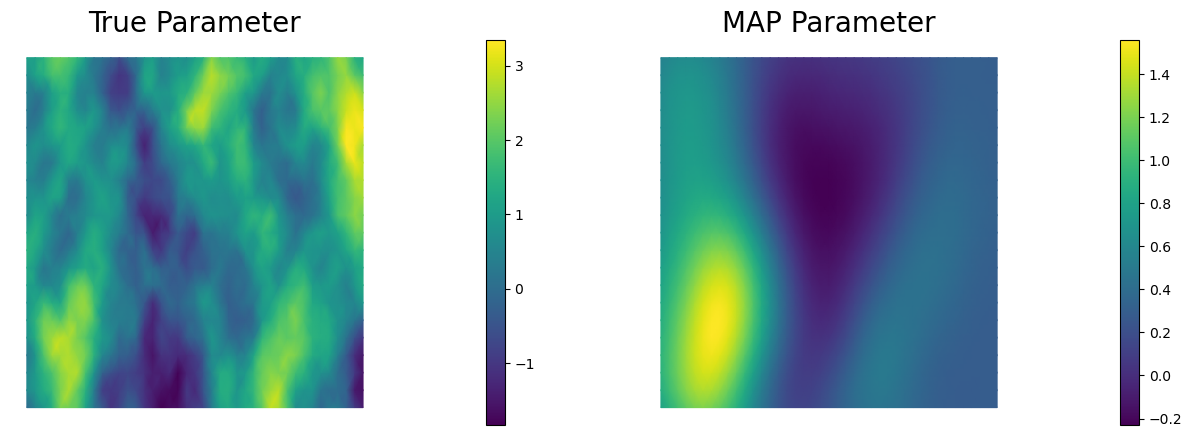

In [7]:
# Plot MAP point
plt.figure(figsize=(15,5))
nb.plot(dl.Function(model.problem.Vh[hp.PARAMETER],mtrue), subplot_loc=121,mytitle="True Parameter")
nb.plot(dl.Function(model.problem.Vh[hp.PARAMETER], x[hp.PARAMETER]), subplot_loc=122,mytitle="MAP Parameter")
plt.show()

Single/Double Pass Algorithm. Requested eigenvectors: 50; Oversampling 20.


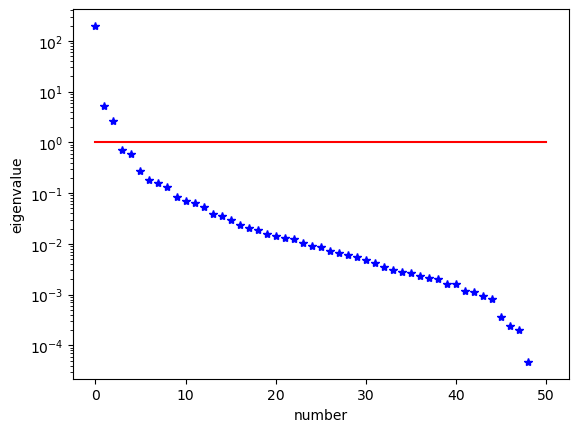

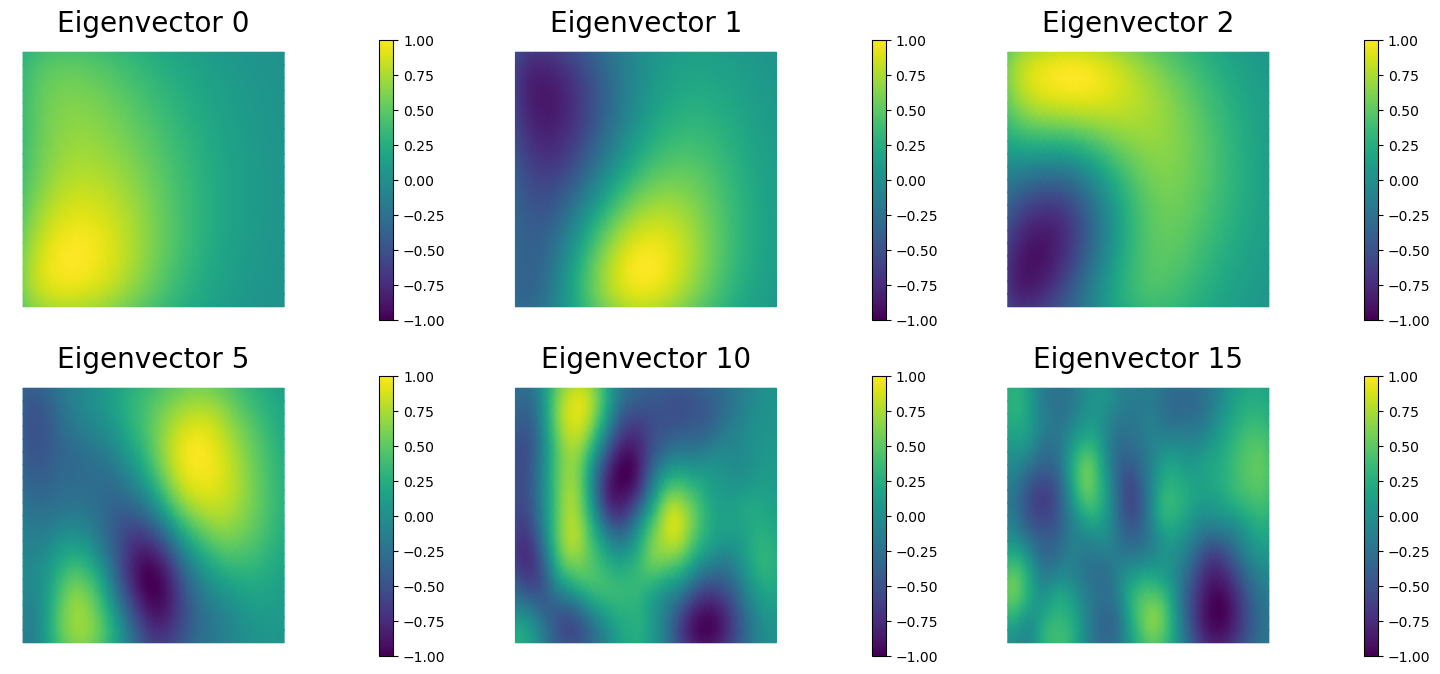

In [8]:
model.setPointForHessianEvaluations(x, gauss_newton_approx=False)
Hmisfit = hp.ReducedHessian(model, misfit_only=True)
k = 50
p = 20
print( "Single/Double Pass Algorithm. Requested eigenvectors: {0}; Oversampling {1}.".format(k,p) )

Omega = hp.MultiVector(x[hp.PARAMETER], k+p)
hp.parRandom.normal(1., Omega)
lmbda, V = hp.doublePassG(Hmisfit, model.prior.R, model.prior.Rsolver, Omega, k)

posterior = hp.GaussianLRPosterior(model.prior, lmbda, V)
posterior.mean = x[hp.PARAMETER]

plt.plot(range(0,k), lmbda, 'b*', range(0,k+1), np.ones(k+1), '-r')
plt.yscale('log')
plt.xlabel('number')
plt.ylabel('eigenvalue')

nb.plot_eigenvectors(model.problem.Vh[hp.PARAMETER], V, mytitle="Eigenvector", which=[0,1,2,5,10,15])